# Data

In [1]:
import sys
sys.path.insert(0, "..")

cone_path = "/eis_toolkit/tests/data/remote/raster_cone.tif"
small_path = "/eis_toolkit/tests/data/remote/small_raster.tif"

# Helper

## Plots

In [2]:
import math
import matplotlib.pyplot as plt

def plots_side_by_side(box_width, box_heigth, *argv):
    """plot multiple images side by side"""
      
    # columns and rows
    num_cols = 5
    
    if isinstance(argv[0], str):
      num_images = 1
    elif isinstance(argv[0], tuple):
      num_images = len(argv)
            
    num_rows = math.ceil(num_images/num_cols)
    
    # plot
    plt.figure(figsize=(box_width*num_cols, box_heigth*num_rows))

    for i in range(0, num_images):
      parameter = argv[i][0] if num_images > 1 else argv[0]
      image = argv[i][1] if num_images > 1 else argv[1]

      plt.subplot(num_rows, num_cols, i+1)
      plt.subplots_adjust(wspace=0.1, hspace=0)
      plt.title(parameter)
      plt.axis("off")
      plt.imshow(image, cmap='viridis')
      plt.colorbar(location='right', shrink=0.5, pad=0.02);
      
      i += 1
      

# Slope and Aspect

## Slope steepness
Valid units are "degree" and "rise".

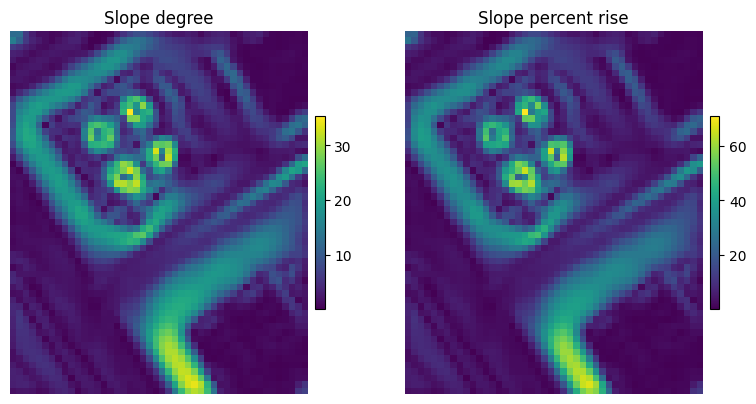

In [3]:
import rasterio
from eis_toolkit.surface_attributes.slope import get_slope

raster = rasterio.open(small_path)
out_slope_deg, out_slope_deg_meta = get_slope(raster, method="Horn81", unit="degrees", scaling_factor=1)
out_slope_rise, out_slope_rise_meta = get_slope(raster, method="Horn81", unit="rise", scaling_factor=1)

plots_side_by_side(5, 5, *(("Slope degree", out_slope_deg),
                           ("Slope percent rise", out_slope_rise)))

## Aspect directions
Valid units are "degree" and "radians".

### Default

/root/.cache/pypoetry/virtualenvs/eis-toolkit-QEzTY9B6-py3.10/lib/python3.10/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


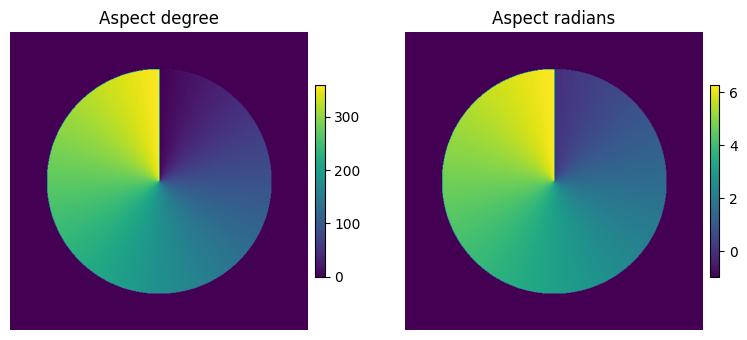

In [4]:
import rasterio
from eis_toolkit.surface_attributes.aspect import get_aspect

raster = rasterio.open(cone_path)
out_aspect_deg, out_aspect_deg_meta = get_aspect(raster, method="Horn81", unit="degrees")
out_aspect_rad, out_aspect_rad_meta = get_aspect(raster, method="Horn81", unit="radians")

plots_side_by_side(5, 5, *(("Aspect degree", out_aspect_deg),
                           ("Aspect radians", out_aspect_rad)))

## Aspect classification
**Mapping** <br>
Mapping for 8 classes: N: 1, NE: 2, E: 3, SE: 4, S: 5, SW: 6, W: 7, NW: 8<br>
Mapping for 16 classes: N: 1, NNE: 2, NE: 3, ENE: 4, E: 5, ESE: 6, SE: 7, SSE: 8, S:9, SSW: 10, SW: 11, SSW: 12, W: 13, WNW: 14, NW: 15, NNW: 16<br>
ND (not defined) will always be mapped as -1.<p>

**Intervals** <br>
Directions and interval for 8 classes:
- N: (337.5, 22.5)
- NE: (22.5, 67.5),
- E: (67.5, 112.5)
-SE: (112.5, 157.5),
- S: (157.5, 202.5)
- SW: (202.5, 247.5),
- W: (247.5, 292.5)
- NW: (292.5, 337.5)

Directions and interval for 16 classes:
- N: (348.75, 11.25)
- NNE: (11.25, 33.75)
- NE: (33.75, 56.25)
- ENE: (56.25, 78.75),
- E: (78.75, 101.25)
- ESE: (101.25, 123.75)
- SE: (123.75, 146.25)
- SSE: (146.25, 168.75),
- S: (168.75, 191.25)
- SSW: (191.25, 213.75)
- SW: (213.75, 236.25)
- WSW: (236.25, 258.75),
- W: (258.75, 281.25)
- WNW: (281.25, 303.75)
- NW: (303.75, 326.25)
- NNW: (326.25, 348.75)

/root/.cache/pypoetry/virtualenvs/eis-toolkit-QEzTY9B6-py3.10/lib/python3.10/site-packages/rasterio/io.py:140: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  return writer(mempath, 'w+', driver=driver, width=width,


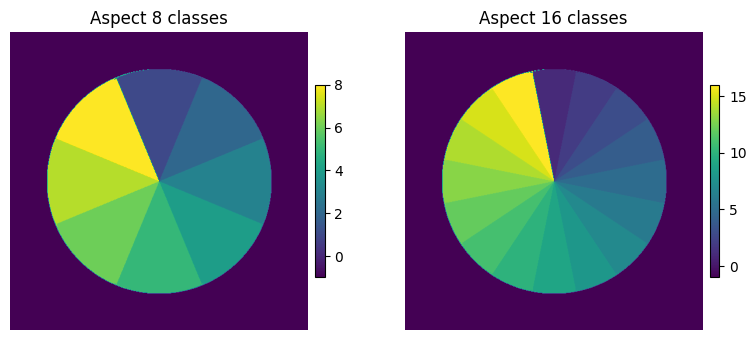

In [5]:
import rasterio
import numpy as np
from eis_toolkit.surface_attributes.aspect import get_aspect, classify_aspect

with rasterio.open(cone_path) as raster:
    # Default settings
    out_array, out_meta = get_aspect(raster, method="Horn81", unit="degrees")

    with rasterio.MemoryFile() as memfile:
        with memfile.open(**out_meta) as aspect:
            aspect.write(out_array, 1)

        with rasterio.MemoryFile(memfile.read()) as dataset_memfile:
            mem_raster = dataset_memfile.open()

            out_aspect_classified_8, out_aspect_mapping_8, out_aspect_meta_8 = classify_aspect(
                raster=mem_raster, unit="degrees", num_classes=8
            )
            
            out_aspect_classified_16, out_aspect_mapping_16, out_aspect_meta_16 = classify_aspect(
                raster=mem_raster, unit="degrees", num_classes=16
            )


plots_side_by_side(5, 5, *(("Aspect 8 classes", out_aspect_classified_8),
                           ("Aspect 16 classes", out_aspect_classified_16)))

## Convertions
For **SLOPE**, valid value range is [0, 90]. Allowed convertions are from **degrees** to **percent rise** and vice versa. A value of 90 results in **infinity**. <br>
For **ASPECT**, valid value range is [0, 360] Allowed convertions are from **degrees** to **radians** and vice versa.

For all convertions, only values >= 0 will be considered.

In [6]:
from eis_toolkit.utilities.conversions import convert_deg_to_rise, convert_rad_to_deg, convert_deg_to_rad, convert_rise_to_degree

raster = rasterio.open(small_path)

# Slope
out_slope_deg, out_slope_deg_meta = get_slope(raster, method="Horn81", unit="degrees", scaling_factor=1)
out_slope_rise, out_slope_rise_meta = get_slope(raster, method="Horn81", unit="rise", scaling_factor=1)

out_slope_deg_to_rise = convert_deg_to_rise(out_slope_deg)
out_slope_rise_to_deg = convert_rise_to_degree(out_slope_rise)

# Aspect
out_aspect_deg, out_aspect_deg_meta = get_aspect(raster, method="Horn81", unit="degrees")
out_aspect_rad, out_aspect_rad_meta = get_aspect(raster, method="Horn81", unit="radians")

out_aspect_deg_to_rad = convert_deg_to_rad(out_aspect_deg)
out_aspect_rad_to_deg = convert_rad_to_deg(out_aspect_rad)
